# 1- import libraries


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, roc_auc_score,
    roc_curve, f1_score, precision_score, recall_score
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings("ignore")

# Load dataset From Ucl

In [10]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
columns = [
    "checking_status", "duration", "credit_history", "purpose", "credit_amount", "savings",
    "employment", "installment_rate", "personal_status", "other_debtors", "residence_since",
    "property", "age", "other_installment", "housing", "existing_credits", "job",
    "num_dependents", "telephone", "foreign_worker", "target"
]
df = pd.read_csv(url, sep=' ', header=None, names=columns)

# Encode target
df["target"] = df["target"].map({1: 1, 2: 0})

# Label encode categoricals
categorical_columns = df.select_dtypes(include=["object"]).columns
for col in categorical_columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Split Data With Train Test Split

In [13]:
X = df.drop("target", axis=1)
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE To Handle Imbalance

In [16]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# Grid Search For RandomForest

In [19]:
rf_params = {
    'n_estimators': [100, 150],
    'max_depth': [4, 6],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train_resampled, y_train_resampled)
best_rf = rf_grid.best_estimator_
best_rf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Grid Search For XGBoost

In [22]:
xgb_params = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}
xgb_grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    xgb_params, cv=3, scoring='f1', n_jobs=-1
)
xgb_grid.fit(X_train_resampled, y_train_resampled)
best_xgb = xgb_grid.best_estimator_
best_xgb.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:13:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:13:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:13:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:13:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

# Model Evaluation & Comparison

In [24]:
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'F1 Score': [f1_score(y_test, y_pred_rf), f1_score(y_test, y_pred_xgb)],
    'Precision': [precision_score(y_test, y_pred_rf), precision_score(y_test, y_pred_xgb)],
    'Recall': [recall_score(y_test, y_pred_rf), recall_score(y_test, y_pred_xgb)],
    'AUC': [roc_auc_score(y_test, y_proba_rf), roc_auc_score(y_test, y_proba_xgb)]
}).round(4)

print("📋 Model Comparison:\n")
print(comparison_df)

📋 Model Comparison:

           Model  F1 Score  Precision  Recall     AUC
0  Random Forest    0.8178     0.8594  0.7801  0.8332
1        XGBoost    0.8613     0.8872  0.8369  0.8596


## ROC Curve

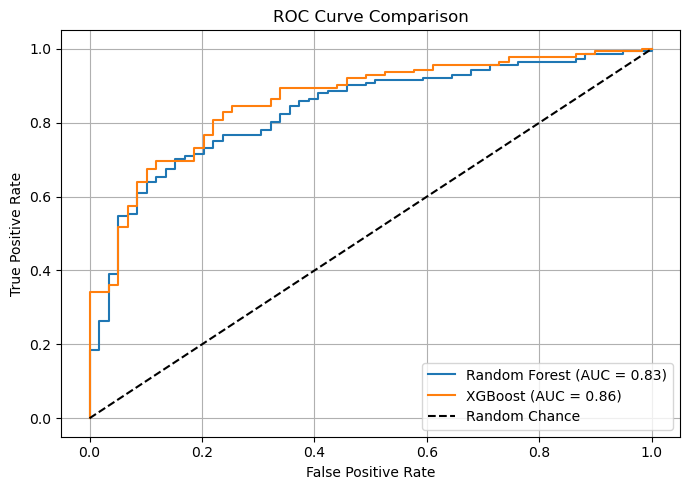

In [28]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

plt.figure(figsize=(7, 5))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba_rf)))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba_xgb)))
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## BarPlot Comparison

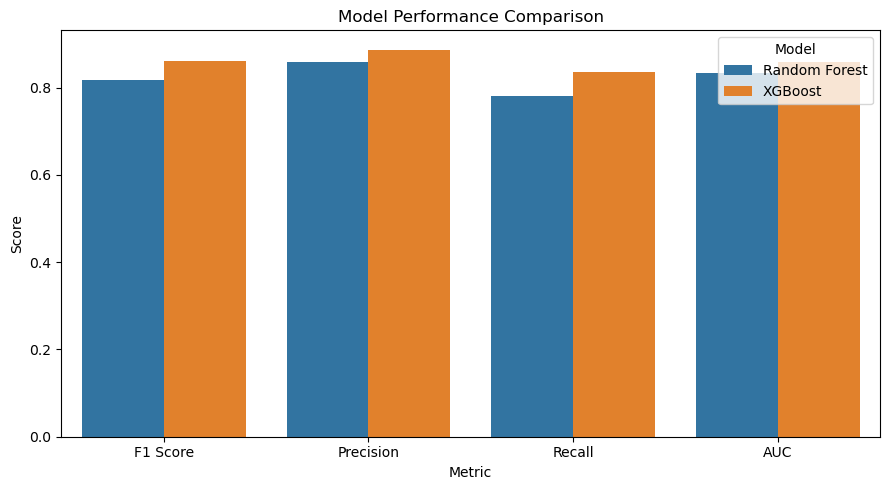

In [31]:
metrics_long = comparison_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(9, 5))
sns.barplot(data=metrics_long, x='Metric', y='Score', hue='Model')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

## SHAP

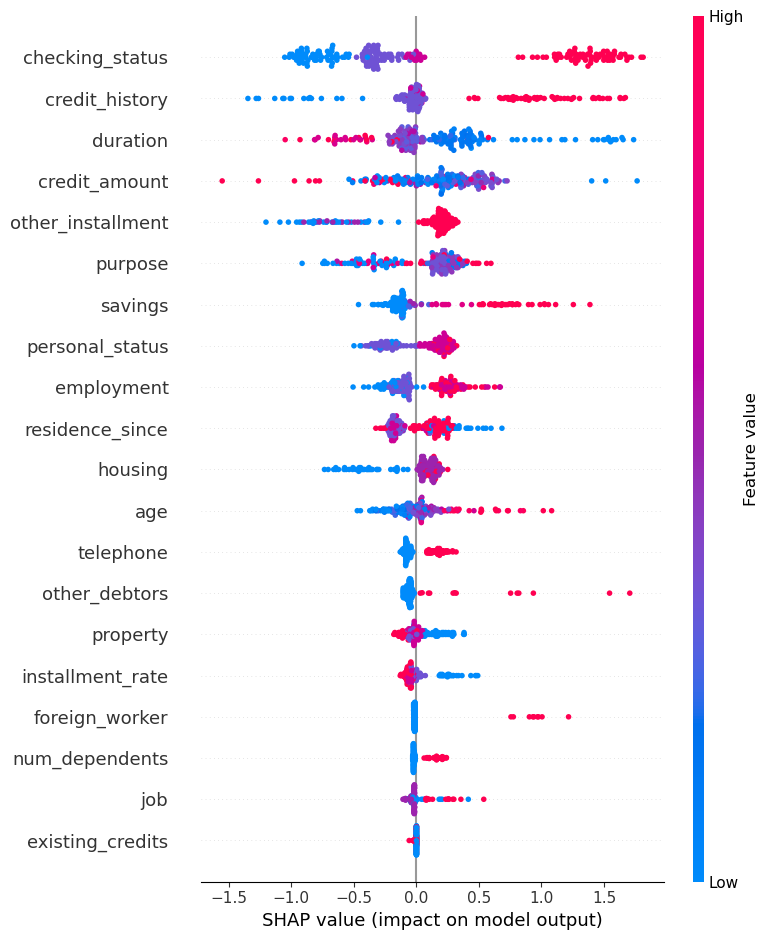

In [34]:
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.show()

## wilcoxon


In [45]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [82]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# Calculate F1 scores for each fold
xgb_f1_scores = cross_val_score(xgb_model, X, y, cv=skf, scoring='f1')
rf_f1_scores  = cross_val_score(rf_model, X, y, cv=skf, scoring='f1')


print("XGBoost F1 Scores per fold:", xgb_f1_scores)
print("Random Forest F1 Scores per fold:", rf_f1_scores)

XGBoost F1 Scores per fold: [0.83221477 0.85314685 0.82269504 0.78911565 0.81944444 0.80263158
 0.83916084 0.85135135 0.8590604  0.84353741]
Random Forest F1 Scores per fold: [0.85185185 0.8447205  0.84415584 0.82208589 0.86419753 0.82278481
 0.8427673  0.8427673  0.85534591 0.85714286]


In [84]:
from scipy.stats import wilcoxon


# Perform the Wilcoxon Signed-Rank test
statistic, p_value = wilcoxon(xgb_f1_scores, rf_f1_scores)


print("Wilcoxon Signed-Rank Test Results:")
print(f"Test Statistic = {statistic}")
print(f"P-value = {p_value}")

# Interpretation
if p_value < 0.05:
    print("There is a statistically significant difference between the two models.")
else:
    print("No statistically significant difference found between the two models.")

Wilcoxon Signed-Rank Test Results:
Test Statistic = 9.0
P-value = 0.064453125
No statistically significant difference found between the two models.
